# Model results and figures

In [1]:
# Importing packages + magics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Importing python module(s)
import model_functions as model

# code for saving figure:
# plt.savefig('figures/cumulative_labor', dpi=300, bbox_inches='tight')

In [2]:
# Plotting settings
#figure settings
import seaborn as sns
sns.set(style='ticks', palette=['#88CCEE','#CC6677','#DDCC77','#117733','#332288','#AA4499','#44AA99','#999933','#882255','#661100','#6699CC','#888888'])

SMALL_SIZE = 10
MEDIUM_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title

## Figure 1: Simulering af en Geometric Brownian Motion

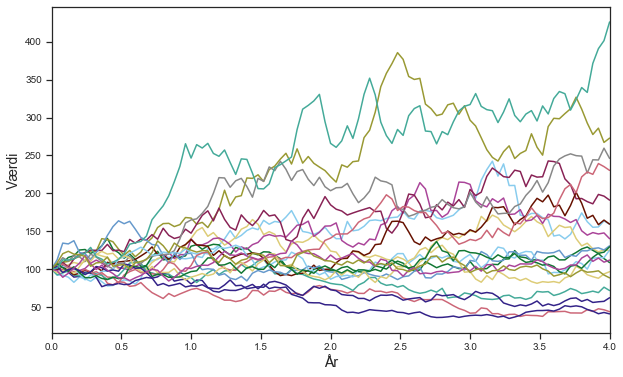

In [3]:
sim_model = model.CLOModel(T = 4, n = 20) # model instance
time = np.linspace(0, sim_model.T, sim_model.m+1) # time with freq+1 steps
tt = np.full(shape=(sim_model.n, sim_model.m+1), fill_value = time).T
sim_array = sim_model.GBM_fig()

# Plotting
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(tt, sim_array);
ax.set_xlim(0, sim_model.T)
ax.set_xlabel('År');
ax.set_ylabel('Værdi');
# plt.savefig('figures/GBM_simulation', dpi=300, bbox_inches='tight')

## Figur 4: SPV cashflow fordeling

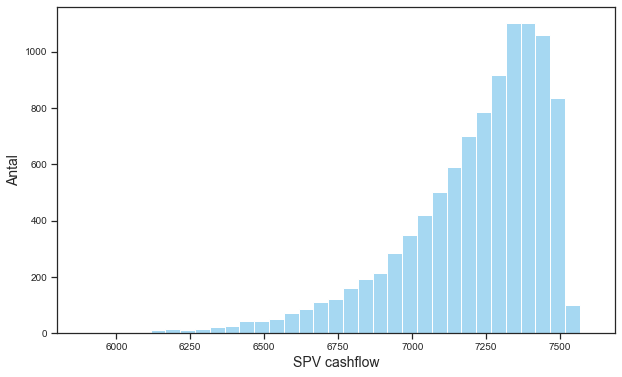

In [4]:
fig_model = model.CLOModel(n=10000)
data = fig_model.SPV_value()

fig, ax = plt.subplots(1,1, figsize=(10,6))

sns.histplot(data, binwidth=50)
ax.set_xlabel('SPV cashflow')
ax.set_ylabel('Antal')
ax.set_xlim(left=5800);

# plt.savefig('figures/SPV_cashflow', dpi=300, bbox_inches='tight')

## Figur 3: Figurnavn?

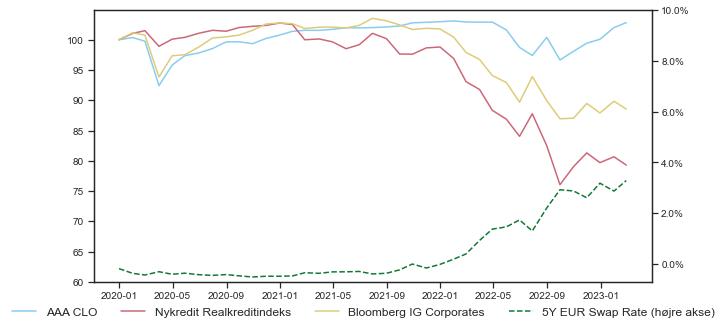

In [5]:
df_fig = pd.read_excel('data\historical_performance.xlsx')
df_fig.set_index('date', inplace=True)

fig, ax1 = plt.subplots(1,1, figsize=(10,5))
ax2 = ax1.twinx() # second y-axis

# plotting on the left axis
ax1.plot(df_fig['CLO_AAA'], label='AAA CLO');
# ax1.plot(df_fig['CLO_BBB'], label='BBB CLO');
ax1.plot(df_fig['nykredit'], label='Nykredit Realkreditindeks');
ax1.plot(df_fig['bloomberg'], label='Bloomberg IG Corporates');

# plotting on the right axis
ax2._get_lines.prop_cycler = ax1._get_lines.prop_cycler
ax2.plot(df_fig['eur_swap'], label='5Y EUR Swap Rate (højre akse)', linestyle='--')

# additional cosmetics
ax1.set_ylim(bottom=60)
ax2.set_ylim(top=0.10)
ax2.yaxis.set_major_formatter(FuncFormatter('{:.1%}'.format))
fig.legend(loc='lower center', frameon=False, ncol=len(df_fig));
# plt.savefig('figures/yields_and_interest', dpi=300, bbox_inches='tight')

## Table 1: Tabelnavn?

In [85]:
fig_model = model.CLOModel(n=10_000)
table = fig_model.result_table()

In [86]:
table.round(2)

,default probability,aggregate face value,aggregate market value,face value,market value,kurs,afkast,spread
Rating,,,,,,,,
AAA,0.09,4541.14,4447.68,4541.14,4447.68,97.94,0.42,0.02
AA,0.30,4777.20,4673.29,236.06,225.61,95.58,0.91,0.51
A,0.44,4847.04,4738.81,69.85,65.52,93.81,1.28,0.88
BBB,1.48,5078.26,4948.70,231.21,209.89,90.78,1.94,1.54
BB,6.19,5369.84,5183.77,291.58,235.07,80.62,4.31,3.91
B,16.67,5580.30,5311.70,210.46,127.94,60.79,9.96,9.56


## Figure: Cash flows sensitivity to rf-change

In [60]:
rf_array = np.arange(0.005, 0.06, step=0.005)
rating = 'B'
data = np.empty(len(rf_array))
for i, rate in enumerate(rf_array):
    fig_model = model.CLOModel(rf=rate)
    data_df = fig_model.result_table()
    # print(f'rf={rate}, spread={data_df.loc['AAA', 'spread']}')
    data[i] = data_df.loc[rating, 'spread']

Text(0, 0.5, 'Spread')

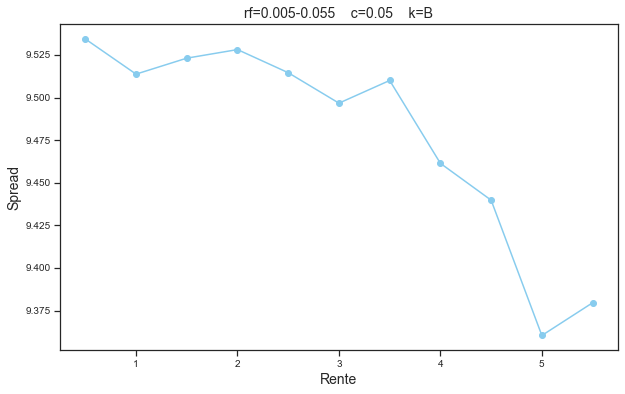

In [61]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(rf_array*100, data, marker='o')
ax.set_title(f'rf={rf_array[0]}-{rf_array[-1]}    c={fig_model.c}    k={rating}')
ax.set_xlabel('Rente')
ax.set_ylabel('Spread')

In [11]:
rf_array = np.arange(0.035, 0.1, step=0.010)

for i, rate in enumerate(rf_array):
    fig_model = model.CLOModel(rf=rate, n=10_000)
    data_df = fig_model.result_table()
    spread = data_df.loc['AAA', 'spread']
    afkast = data_df.loc['AAA', 'afkast']
    print(f'rf={rate:.3f}, spread={spread:.3f}, yield={afkast:.3f}')

rf=0.035, spread=0.001, yield=3.501
rf=0.045, spread=0.001, yield=4.501
rf=0.055, spread=0.001, yield=5.501
rf=0.065, spread=0.001, yield=6.501
rf=0.075, spread=0.001, yield=7.501
rf=0.085, spread=0.001, yield=8.501
rf=0.095, spread=0.000, yield=9.500


## SENSITIVITY: rf effekt på face value B-hat

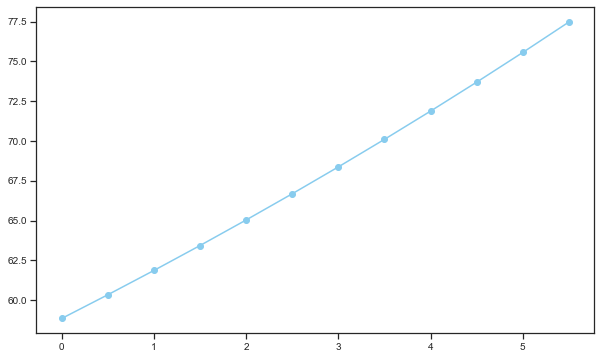

In [87]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
rf_array = np.arange(0, 0.06, step=0.005)
data = np.empty(len(rf_array))

for i, rate in enumerate(rf_array):
    fig_model = model.CLOModel(rf=rate, n=5000)
    data[i] = fig_model.face_value()
    
ax.plot(rf_array*100, data, marker='o')

## SENSITIVITY: rf effekt på SPV cash-flow fordeling (P & Q)

Text(0, 0.5, 'Sandsynlighedstæthed')

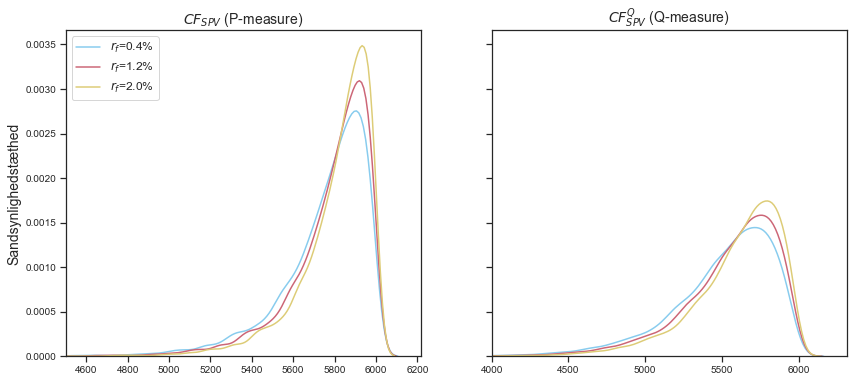

In [106]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6), sharey=True)
rf_array = np.array([0.004, 0.012, 0.02]) # risk free rates

for rate in rf_array:
    fig_model = model.CLOModel(rf=rate)
    SPV_P = fig_model.SPV_value()
    SPV_Q = fig_model.SPV_value(risk_neutral=True)
    sns.kdeplot(SPV_P, ax=ax1, label=f'$r_f$={rate*100}%') # left axis (P-measure)
    sns.kdeplot(SPV_Q, ax=ax2) # right axis (Q-measure)
    
ax1.legend()
ax1.set_xlim(left=4500)
ax2.set_xlim(left=4000)
ax1.set_title('$CF_{SPV}$ (P-measure)')
ax2.set_title('$CF_{SPV}^Q$ (Q-measure)')
ax1.set_ylabel('Sandsynlighedstæthed')

## SENSITIVITY: rf ændring effekt på market value W

In [230]:
rf_array = np.array([0.004, 0.012, 0.02])

data_agg = []
data_tranche = []
for rate in rf_array:
    fig_model = model.CLOModel(n=1000, rf=rate)
    result_table = fig_model.result_table()
    data_agg.append(result_table['aggregate market value'].to_list())
    data_tranche.append(result_table['market value'].to_list())
    
data_agg = np.array(data_agg)
data_tranche = np.array(data_tranche)
data_tranche = data_tranche / data_tranche[0,:] * 100

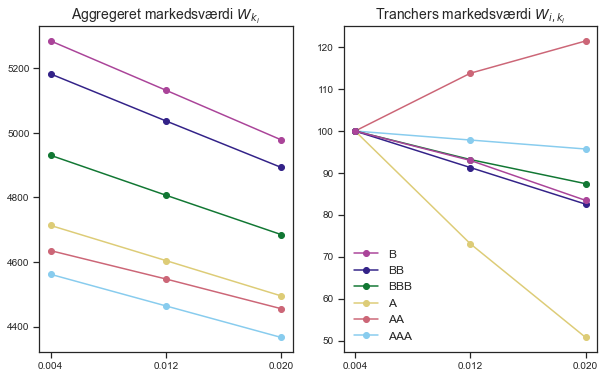

In [249]:
fig, ax = plt.subplots(1,2, figsize=(10,6))

for i, rating in enumerate(['AAA', 'AA', 'A', 'BBB', 'BB', 'B']):
    ax[0].plot(rf_array, data_agg[:,i], marker='o', label=f'{rating}')
    ax[1].plot(rf_array, data_tranche[:,i], marker='o')
    
handles, labels = ax[0].get_legend_handles_labels()
ax[1].legend(handles[::-1], labels[::-1], frameon=False)
ax[0].set_xticks(rf_array)
ax[1].set_xticks(rf_array)

ax[0].set_title('Aggregeret markedsværdi $W_{k_i}$')
ax[1].set_title('Tranchers markedsværdi $W_{i,k_i}$');

## SENSITIVITY: rf ændring effekt på W/B (markedsværdi / face value)

In [259]:
rf_array = np.array([0.004, 0.012, 0.02])

data_agg_W = []
data_agg_B = []
data_tranche_W = []
data_tranche_B = []
for rate in rf_array:
    fig_model = model.CLOModel(n=1000, rf=rate)
    result_table = fig_model.result_table()
    data_agg_W.append(result_table['aggregate market value'].to_list())
    data_agg_B.append(result_table['aggregate face value'].to_list())
    data_tranche_W.append(result_table['market value'].to_list())
    data_tranche_B.append(result_table['face value'].to_list())

data_agg = np.array(data_agg_W) / np.array(data_agg_B)
data_tranche = np.array(data_tranche_W) / np.array(data_tranche_B)
# data_tranche = data_tranche / data_tranche[0,:] * 100

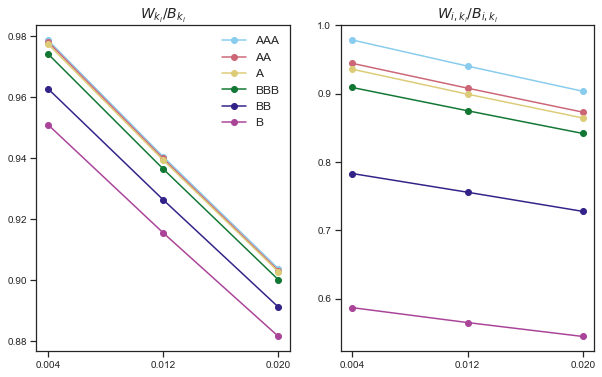

In [260]:
fig, ax = plt.subplots(1,2, figsize=(10,6))

for i, rating in enumerate(['AAA', 'AA', 'A', 'BBB', 'BB', 'B']):
    ax[0].plot(rf_array, data_agg[:,i], marker='o', label=f'{rating}')
    ax[1].plot(rf_array, data_tranche[:,i], marker='o')
    
# handles, labels = ax[0].get_legend_handles_labels()
# ax[0].legend(handles[::-1], labels[::-1], frameon=False)
ax[0].legend(frameon=False)
ax[0].set_xticks(rf_array)
ax[1].set_xticks(rf_array)

ax[0].set_title('$W_{k_i} / B_{k_i}$')
ax[1].set_title('$W_{i,k_i} / B_{i,k_i}$');

# Recycle Bin

## Figure 2: SPV cash flow histogram